# Some 2 cents of mine

I did some feature engineering and correlation analyasis on news data compared to the target 'returnsOpenNextMktres10', but didn't find strong correlations.

Now, I believe that the values from market_train_df already incorporate news.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My\ Drive/2sigma/data/raw

/content/drive/My Drive/2sigma/data/raw


# Import Environment

In [0]:
# Import some libraries
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # graphing
import os
from datetime import datetime, timedelta # Used to subtract days from a date
import seaborn as sb

# print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.


# Load Initial Market & News Train Data

In [0]:
# Import training dataset
market_train_df = pd.read_csv('market_train_uni1_v1.csv')
news_train_df = pd.read_csv('news_market_train_uni1_v1.csv')

# View Correlation Heatmap Pre-processing

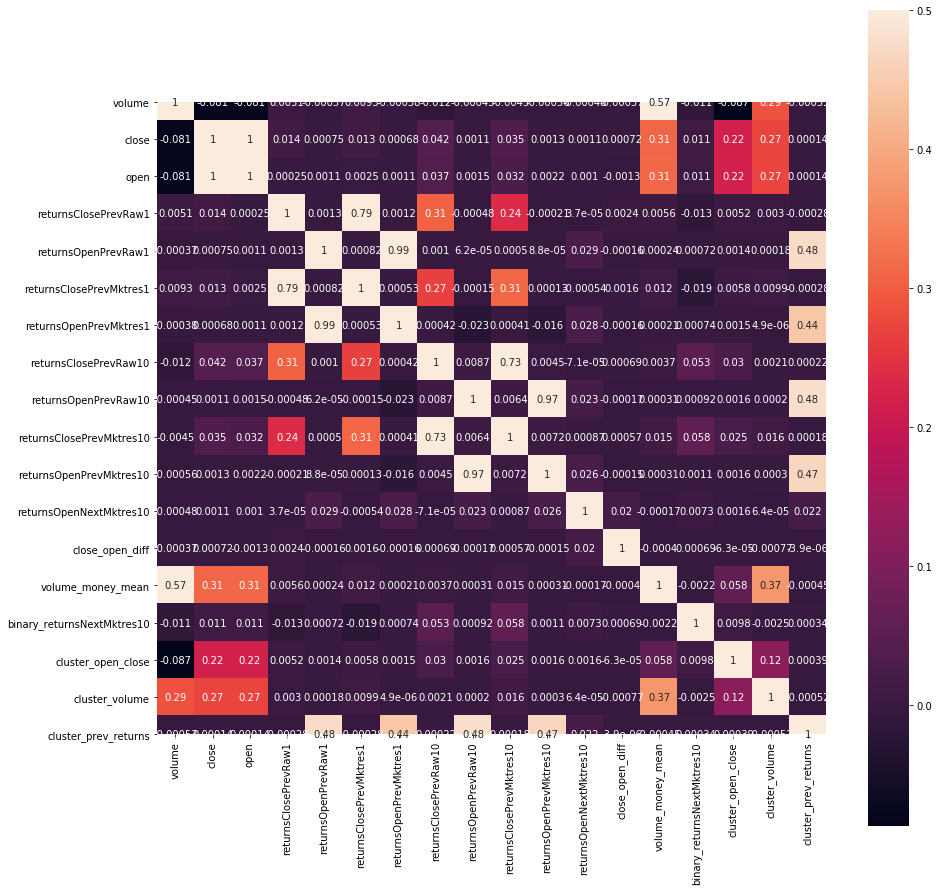

In [6]:
# Heat map with market_train_df
C_mat = market_train_df.corr()
fig = plt.figure(figsize=(15,15))
sb.heatmap(C_mat,vmax=0.5,square=True,annot=True)
plt.show()

# View Correlation Heatmap after removing outliers

Number of data decreased from  2423150  to  1975767


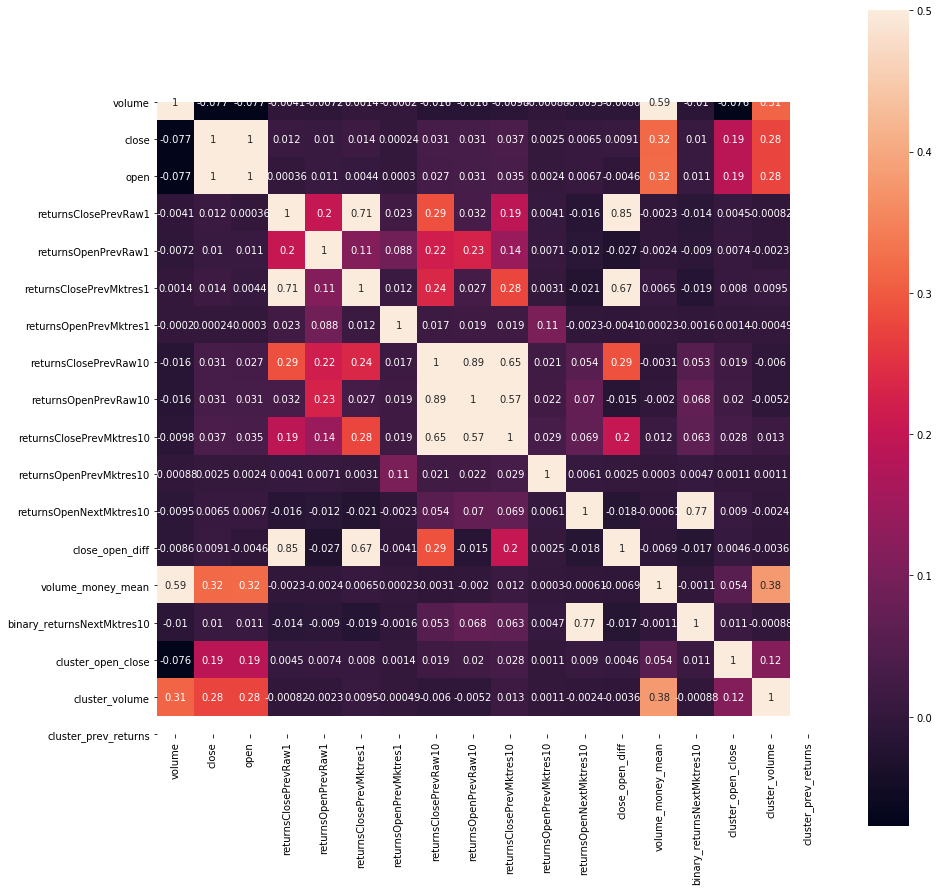

In [7]:
def remove_outlier(df,column_list,lower_percentile,upper_percentile):
    for i in range(len(column_list)):
        #upper_bound = np.percentile(df[column_list[i]],upper_percentile)
        #lower_bound = np.percentile(df[column_list[i]],lower_percentile)
        df = (df[(df[column_list[i]]<np.percentile(df[column_list[i]],upper_percentile)) & (df[column_list[i]]>np.percentile(df[column_list[i]],lower_percentile))])
    return df
#outlier_removal_list = ['returnsClosePrevRaw1','returnsOpenPrevRaw1','returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevRaw10','returnsOpenPrevRaw10','returnsClosePrevMktres10','returnsOpenPrevMktres10','returnsOpenNextMktres10']
outlier_removal_list = [ 'returnsClosePrevRaw1',
                         'returnsOpenPrevRaw1',
                         'returnsClosePrevRaw10',
                         'returnsOpenPrevRaw10',
                         'returnsOpenNextMktres10']

market_data_no_outlier = remove_outlier(market_train_df,outlier_removal_list,2,98)
print("Number of data decreased from ",len(market_train_df['returnsOpenNextMktres10'])," to ",len(market_data_no_outlier['returnsOpenNextMktres10']))

C_mat = market_data_no_outlier.corr()
fig = plt.figure(figsize=(15,15))
sb.heatmap(C_mat,vmax=0.5,square=True,annot=True)
plt.show()

# Process Market Data - Drop Rows with NaN Values

In [0]:
# proces data
def process_merged_data(df):
    # Drop rows with NaN values
    df = df.dropna()
    # Let's choose our features#
    features = ['time','returnsClosePrevRaw1','returnsOpenPrevRaw1','returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevRaw10','returnsOpenPrevRaw10','returnsClosePrevMktres10','returnsOpenPrevMktres10']
    x = df[features]
    y = df[['time','returnsOpenNextMktres10']]
    return x,y

market_data_no_outlier,market_data_no_outlier_target = process_merged_data(market_data_no_outlier)

# Standardize Data

In [0]:
from sklearn.preprocessing import StandardScaler
def scale_data(df,features):
    scaler = StandardScaler()
    df[features]=scaler.fit_transform(df[features])
    return df
features = ['returnsClosePrevRaw1',
         'returnsOpenPrevRaw1',
         'returnsClosePrevMktres1',
         'returnsOpenPrevMktres1',
         'returnsClosePrevRaw10',
         'returnsOpenPrevRaw10',
         'returnsClosePrevMktres10',
         'returnsOpenPrevMktres10']    
market_data_no_outlier_scaled = scale_data(market_data_no_outlier,features)

# View Final Correlation Heatmap before Training

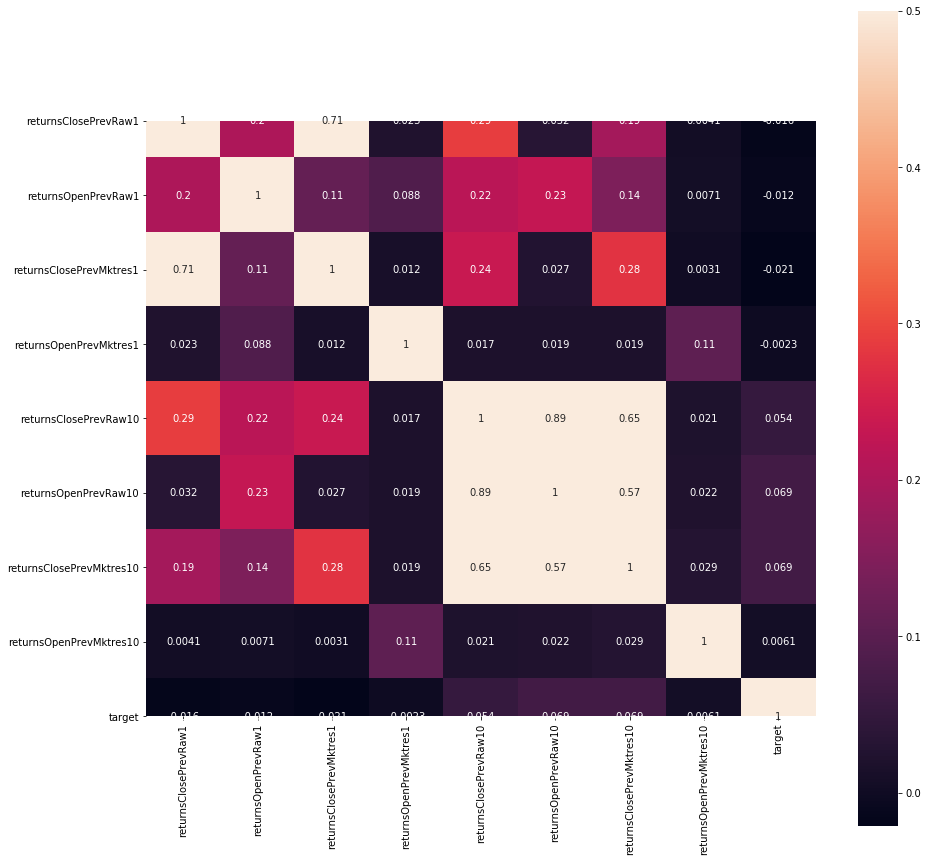

In [10]:
# Heat map with merged_data
features = ['returnsClosePrevRaw1',
         'returnsOpenPrevRaw1',
         'returnsClosePrevMktres1',
         'returnsOpenPrevMktres1',
         'returnsClosePrevRaw10',
         'returnsOpenPrevRaw10',
         'returnsClosePrevMktres10',
         'returnsOpenPrevMktres10']
temp_show = market_data_no_outlier_scaled[features]
temp_show['target']=market_data_no_outlier_target['returnsOpenNextMktres10']
C_mat = temp_show.corr()
fig = plt.figure(figsize=(15,15))
sb.heatmap(C_mat,vmax=0.5,square=True,annot=True)
plt.show()
del temp_show

# Split Data for Training and Validation(Testing) & Choose Final Features

In [12]:
market_data_no_outlier_scaled.dtypes

time                         object
returnsClosePrevRaw1        float64
returnsOpenPrevRaw1         float64
returnsClosePrevMktres1     float64
returnsOpenPrevMktres1      float64
returnsClosePrevRaw10       float64
returnsOpenPrevRaw10        float64
returnsClosePrevMktres10    float64
returnsOpenPrevMktres10     float64
dtype: object

In [16]:
market_data_no_outlier_target.dtypes

time                        object
returnsOpenNextMktres10    float64
dtype: object

In [0]:
market_data_no_outlier_scaled['time'] = pd.to_datetime(market_data_no_outlier_scaled['time'])

In [0]:
market_data_no_outlier_target['time'] = pd.to_datetime(market_data_no_outlier_target['time'])

In [18]:
# Splits data for training. Takes out 30 days worth of data between training and validation set to prevent data leakage
def split_train_test(x,y,test_size):    
    # Splits data as specified test_size and creates a gap of 30 days between train and test. This helps data leakage so that the model doesn't know the future when training
    X_train = x[x['time']<(x['time'][int(len(x)*(1-test_size))]-timedelta(days=30))]
    y_train = y[y['time']<(y['time'][int(len(x)*(1-test_size))]-timedelta(days=30))]
    X_test = x[x['time']>x['time'][int(len(x)*(1-test_size))]]
    y_test = y[y['time']>y['time'][int(len(y)*(1-test_size))]]   
    # Final Features to be used
    #features = ['returnsClosePrevRaw1','returnsOpenPrevRaw1','returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevRaw10','returnsOpenPrevRaw10','returnsClosePrevMktres10','returnsOpenPrevMktres10'] 
    features = ['returnsClosePrevRaw10','returnsOpenPrevRaw10','returnsClosePrevMktres10']
    
    X_train1 = X_train[features].copy()
    y_train1 = y_train['returnsOpenNextMktres10'].copy()
    train_time = y_train['time']
    
    X_test1 = X_test[features].copy()
    y_test1 = y_test['returnsOpenNextMktres10'].copy()
    test_time = y_test['time']
    return X_train1,X_test1,y_train1,y_test1,train_time,test_time

X_train,X_test,y_train,y_test,train_time,test_time = split_train_test(market_data_no_outlier_scaled,market_data_no_outlier_target,0.1)
print("Test data percentage : {} %".format(len(X_test)/(len(X_train)+len(X_test))*100))


Test data percentage : 29.004740752031786 %


In [32]:
X_train.head()

,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10
8717,0.941456,0.414224,0.866417
8718,0.565272,-0.696302,0.749350
8719,-0.013240,-0.364746,-0.486777
8720,0.406917,0.146201,0.200080
8721,1.054639,0.596907,1.482512


In [33]:
y_train.head()

8717   -0.029993
8718   -0.028244
8719   -0.014505
8720    0.017172
8721    0.022841
Name: returnsOpenNextMktres10, dtype: float64

# Deep Neural Network

### Define Model

In [0]:
# Model
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Input
from keras.optimizers import Adam

# Initialize Model
model = Sequential()
# Input layer & hidden layer
model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32,activation='relu'))
# Output layer
model.add(Dense(1))
# Compile the architecture and view summary
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()


### Early stopping callback :

In [0]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_acc', verbose = 1, save_best_only = True, mode ='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto',restore_best_weights=True)
callbacks_list = [early_stopping]
#callbacks_list = [checkpoint,early_stopping]

### Train the model

In [21]:
model.fit(x=X_train.values,y=y_train.values, epochs=20,shuffle=True,validation_data=(X_test.values, y_test.values),callbacks=callbacks_list)# validation_split=0.2)#) #, callbacks=callbacks_list)




Train on 1378647 samples, validate on 563239 samples
Epoch 1/20





1378647/1378647 [==============================] - 143s 104us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 2/20
1378647/1378647 [==============================] - 139s 101us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3/20
1378647/1378647 [==============================] - 138s 100us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/20
1378647/1378647 [==============================] - 138s 100us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/20
1378647/1378647 [==============================] - 138s 100us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/20
1378647/1378647 [==============================] - 138s 100us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 7/20
1378647/1378647 [==============================] - 139s 101us/step - loss: 0.0017 - val_loss: 0.0015
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping


### Sanity Check. Real vs Pred values

In [38]:
X_test.head()

,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10
1766028,0.288056,0.016865,-0.016195
1766029,0.400704,0.311618,0.382526
1766030,0.109674,-0.161212,0.677955
1766031,-0.271605,-0.401488,-0.355281
1766032,1.339936,1.158565,0.861331


In [29]:
data = {'y_real':y_test[:5],'y_pred':(model.predict(X_test.values[:5])).reshape(1,-1)[0]}
pd.DataFrame(data)

,y_real,y_pred
1766028,0.019288,-0.000706
1766029,-0.002466,0.003242
1766030,0.045841,0.001952
1766031,0.015759,-0.001286
1766032,0.001014,0.001810


### Simple ConfidenceValue Creation Function from Prediction Values

In [0]:
def make_my_prediction(x):
    my_pred = (model.predict(x)).reshape(1,-1)[0]
    my_pred[my_pred>0]=1
    my_pred[my_pred<0]=-1
    return my_pred

### Sigma Score

In [24]:
# sigma_score function is considered as a custom evaluation metric for xgboost
# example of how custom evaluation function is incorporated into xgboost's training can be found here : https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py
def sigma_score(preds,dval,df):
    
    # get y_target values
    labels = dval
    # call time parameter to be used for grouping, so that we can add x_t values for each day
    df_time = df
    
    #calculate x_t and score as specified by the competition
    x_t = pd.Series(preds*labels)
    x_t_sum = x_t.groupby(df_time).sum()    
    score = (x_t_sum.mean())/(x_t_sum.std())
    return 'sigma_score', round(score,5)

my_pred_test = make_my_prediction(X_test.values)
print("test : ",sigma_score(my_pred_test,y_test,test_time))

my_pred_train = make_my_prediction(X_train.values)
print("train : ",sigma_score(my_pred_train,y_train,train_time))

test :  ('sigma_score', 0.49783)
train :  ('sigma_score', 0.44176)


In [0]:
preds = my_pred_test
dval = y_test
df = test_time
labels = dval
df_time = df
x_t = pd.Series(preds*labels)
x_t_sum = x_t.groupby(df_time).sum()
score = (x_t_sum.mean())/(x_t_sum.std())

In [37]:
labels

1766028    0.019288
1766029   -0.002466
1766030    0.045841
1766031    0.015759
1766032    0.001014
             ...   
2423145   -0.031742
2423146    0.115330
2423147   -0.045221
2423148    0.083367
2423149   -0.016220
Name: returnsOpenNextMktres10, Length: 563239, dtype: float64